In [3]:
import pomegranate as pg
import numpy as np
import librosa
import librosa.display
import pandas as pd
import re
from matplotlib import pyplot as plt
import madmom
import os
from tqdm import tqdm
import json
import circularPitchSpace as cps
import dataloader
import chromagram

Loading...: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


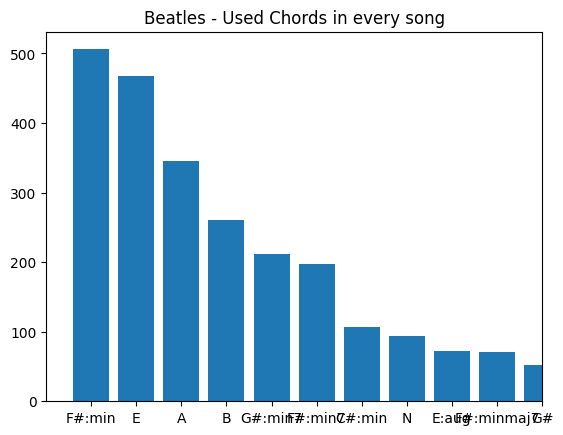

Processing..: 2732it [00:00, 12485.06it/s]
Processing..: 2732it [00:00, 8895.36it/s]


In [2]:
basepath_labels="/home/max/ET-TI/Masterarbeit/prototyping/data/beatles/annotations/chords/"
basepath_audio = "/home/max/ET-TI/Masterarbeit/prototyping/data/beatles/audio/"

songs = dataloader.getBeatlesPaths(basepath_labels,basepath_audio)
# create chromadata
chroma_labels = ["C","C#","D","D#","E","F","F#","G","G#","A","A#","H"]
labels = ["label"]
labels.extend(chroma_labels)

chroma_df = pd.DataFrame(columns=labels)

dcp = madmom.audio.chroma.DeepChromaProcessor()
#for song,audio_path,label_path in tqdm(songs, desc="Loading..."):
for song,audio_path,label_path in tqdm(songs[:2], desc="Loading..."):

    chroma = dcp(audio_path)
    df = pd.DataFrame(chroma,columns=chroma_labels)
    df['label'] = ''
    # parameters used by the deep Chroma Processors are 
    # NFFT=8192, HOPSIZE=4410, FS=44100 -> 10 frames/second
    df['time'] = np.linspace(0.1,len(chroma)*0.1,num=len(chroma))

    # label chroma features by iterating over all annotated chords
    labels_df = pd.read_csv(label_path,sep='\t',names=["tstart","tend","label"])
    for _,col in labels_df.iterrows():
        # access chroma features with time in chord annotation time interval 
        df.loc[(df['time'] >= float(col['tstart'])) & (df['time']< float(col['tend'])),
                    'label'] = col['label']
    chroma_df = pd.concat([chroma_df,df[labels]])
    
    chroma_df.reset_index(drop=True,inplace=True)
    hist = pd.value_counts(chroma_df['label']).to_dict()
    
plt.bar(list(hist.keys()), hist.values())
plt.title("Beatles - Used Chords in every song")
plt.xlim([-1,10])
plt.show()
chroma_df_majmin = dataloader.simplyfyAnnotations(chroma_df,'majmin')
chroma_df_seventh = dataloader.simplyfyAnnotations(chroma_df,'sevenths')

modifizierte Kullback-Leibler Divergenz </br>
$D_{mKL}=\sum_{k=0}^{K-1}ln\big(1+ \frac{|X[k,n]|}{|X[k,n-1]|+\epsilon}\big)$ </br>
Sie ist in maß für die Unterschiede zwischen zwei Wahrscheinlichkeitsverteilungen. </br>
Änderungen im Chromavektor können mit dieser Funktion dedektiert werden.

In [55]:
def movingAverage(data,N=5):
    mean = np.zeros_like(data)
    i = N
    mean[:i] = np.sum(data[:i]/i)
    while i < data.shape[0]:
        # Calculate the average of current window
        mean[i] = np.sum(data[i-N:i])/N
        i += 1
    return mean

def modifiedKullbackLeiblerDivergence(chroma,remove_mean=True,normalize=True):
    if chroma.shape[0] < 2 or chroma.shape[1] != 12:
        raise ValueError("invalid chroma vector")
    X_0 = chroma
    # delay array by one sample
    X_1 = np.zeros_like(X_0)
    X_1[1:,:] = X_0[:-1,:]
    # calculate modified kullback-leibler-divergence
    dkl = np.sum(np.log(1+np.abs(X_0)/(np.abs(X_1)+np.finfo(float).eps)),axis=1)
    # ignore first sample
    dkl[0] = 0.0

    if remove_mean:
        dkl = dkl - movingAverage(dkl,15)
        dkl[dkl<0] = 0.0   
    if normalize:
        dkl = dkl/np.max(dkl)
    return dkl


{'tempo': 60, 'meter': [4, 4], 'chord_prog': ['C', 'Fm', 'C', 'Cm', 'Cm', 'B-m', 'C', 'B-m'], 'chords_per_bar': 1, 'duration_in_bars': 8, 'midi_instrument': 20, 'instr_name': 'Reed Organ', 'volume': 80, 'seed': 4701472408120073403, 'similar_mdata': {'max_allowed_semitone_shift': 2, 'transposition_option': 1, 'time_stretch_option': 1, 'change_instrument': False, 'change_volume': True, 'semitone_offset': 1, 'time_stretched': True}, 'triplet_type': 'positive'}


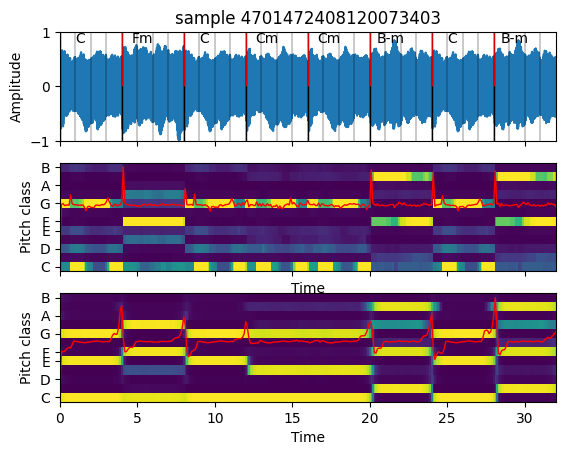

In [57]:
basepath = "/home/max/ET-TI/Masterarbeit/prototyping/data/chord_sequences"
if 1:
    df = dataloader.getChordSequencesPaths(basepath)

# load metadata
sample = 100
with open(df.at[sample,"positive.json"]) as json_file:
    metadata = json.load(json_file)
    print(metadata)
y,fs = librosa.load(df.at[sample,"positive.wav"])
y = librosa.util.normalize(y)
t = np.linspace(0,(len(y)-1)/fs,len(y))
duration = 60/metadata['tempo']
num_beats = metadata['duration_in_bars']*metadata['meter'][0]
beats = np.linspace(0,(num_beats-1)*duration,num_beats)
bars = np.linspace(0,(metadata['duration_in_bars']-1)*metadata['meter'][0]*duration,metadata['duration_in_bars'])
duration_chord = duration * metadata['meter'][0] / metadata['chords_per_bar']
chords = np.linspace(0,(len(metadata['chord_prog'])-1)*duration_chord,len(metadata['chord_prog']))
fig,ax = plt.subplots(3,1,sharex=True)
ax[0].plot(t,y)
ax[0].set_title(f"sample {df.at[sample,'ID']}")
ax[0].set_ylim([-1,1])
ax[0].set_ylabel("Amplitude")
ax[0].set_xlim([0,t[-1]])
for t_beat in beats:
    ax[0].vlines(t_beat,-1,1,'k',linewidth=0.3)
for t_bar in bars:
    ax[0].vlines(t_bar,-1,1,'k',linewidth=1)  
for label,t_chord in zip(metadata['chord_prog'],chords):  
    ax[0].text(t_chord+(duration_chord/3),0.8,label,horizontalalignment='center')
    ax[0].vlines(t_chord,0,1,'r',linestyles='-',linewidth=0.6)  

filepath= df.at[sample,"positive.wav"]
for i,chroma_type in enumerate(['librosa','madmom']):
    chroma = chromagram.getChroma(filepath,chroma_type)
    librosa.display.specshow(chroma.T,n_fft=8192,hop_length=4410,sr=44100, y_axis='chroma',x_axis='time',ax=ax[i+1],cmap='viridis')
    dkl = 11*modifiedKullbackLeiblerDivergence(chroma,remove_mean=True)
    ax[i+1].plot(np.linspace(0,(chroma.shape[0]-1)*4410/44100,chroma.shape[0]),dkl,'r',linewidth=1)

